In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torchvision, torch

In [3]:
import sys, os
sys.path.insert(0,"../torchxrayvision/")
import torchxrayvision as xrv
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
import glob
import numpy as np
import skimage, skimage.filters
%matplotlib inline
import captum, captum.attr
import torch, torch.nn
import pickle
import attribution
import pandas as pd
import datasets
import shutil
import pickle


In [4]:
methods = ["image", "grad", "guided", "integrated", "latentshift-max"]
temp_path = "/lscratch/joecohen/SDS-2342-ASDAA"

In [5]:
ae = xrv.autoencoders.ResNetAE(weights="101-elastic").cuda()

In [6]:
model = xrv.models.DenseNet(weights="all").cuda()

In [19]:
for_eval = {
            "Cardiomegaly":datasets.get_data("nih"),
            'Mass':datasets.get_data("nih"),
            "Atelectasis":datasets.get_data("nih"),
            "Effusion":datasets.get_data("nih"),
            "Lung Opacity":datasets.get_data("rsna"),
            "Pneumothorax":datasets.get_data("siim"),
            }

NIH_Dataset num_samples=67310 views=['PA'] data_aug=None
NIH_Dataset num_samples=67310 views=['PA'] data_aug=None
NIH_Dataset num_samples=67310 views=['PA'] data_aug=None
NIH_Dataset num_samples=67310 views=['PA'] data_aug=None
RSNA_Pneumonia_Dataset num_samples=14511 views=['PA'] data_aug=None
SIIM_Pneumothorax_Dataset num_samples=12954 data_aug=None


In [22]:
import torchvision.transforms.functional as F

In [177]:
data_aug = torchvision.transforms.Compose([
    xrv.datasets.ToPILImage(),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Lambda(lambda x: x + torch.rand(x.shape)*300),
    torchvision.transforms.Lambda(lambda x: x.numpy()),
    torchvision.transforms.Lambda(lambda x: skimage.filters.gaussian(x[0], 
                    mode='constant', 
                    sigma=(0,0), 
                    truncate=3.5)[None,...]),
    ])

In [162]:
#np.where(dmerge.csv.has_masks)

In [163]:
target = "Mass"

In [164]:
dmerge = for_eval[target]

In [170]:
dmerge.data_aug = None
sample = dmerge[175]
image = torch.from_numpy(sample["img"]).unsqueeze(0).cuda()

In [171]:
sample["img"].shape

(1, 224, 224)

tensor([0.2025])
[0.5089496] -190 50


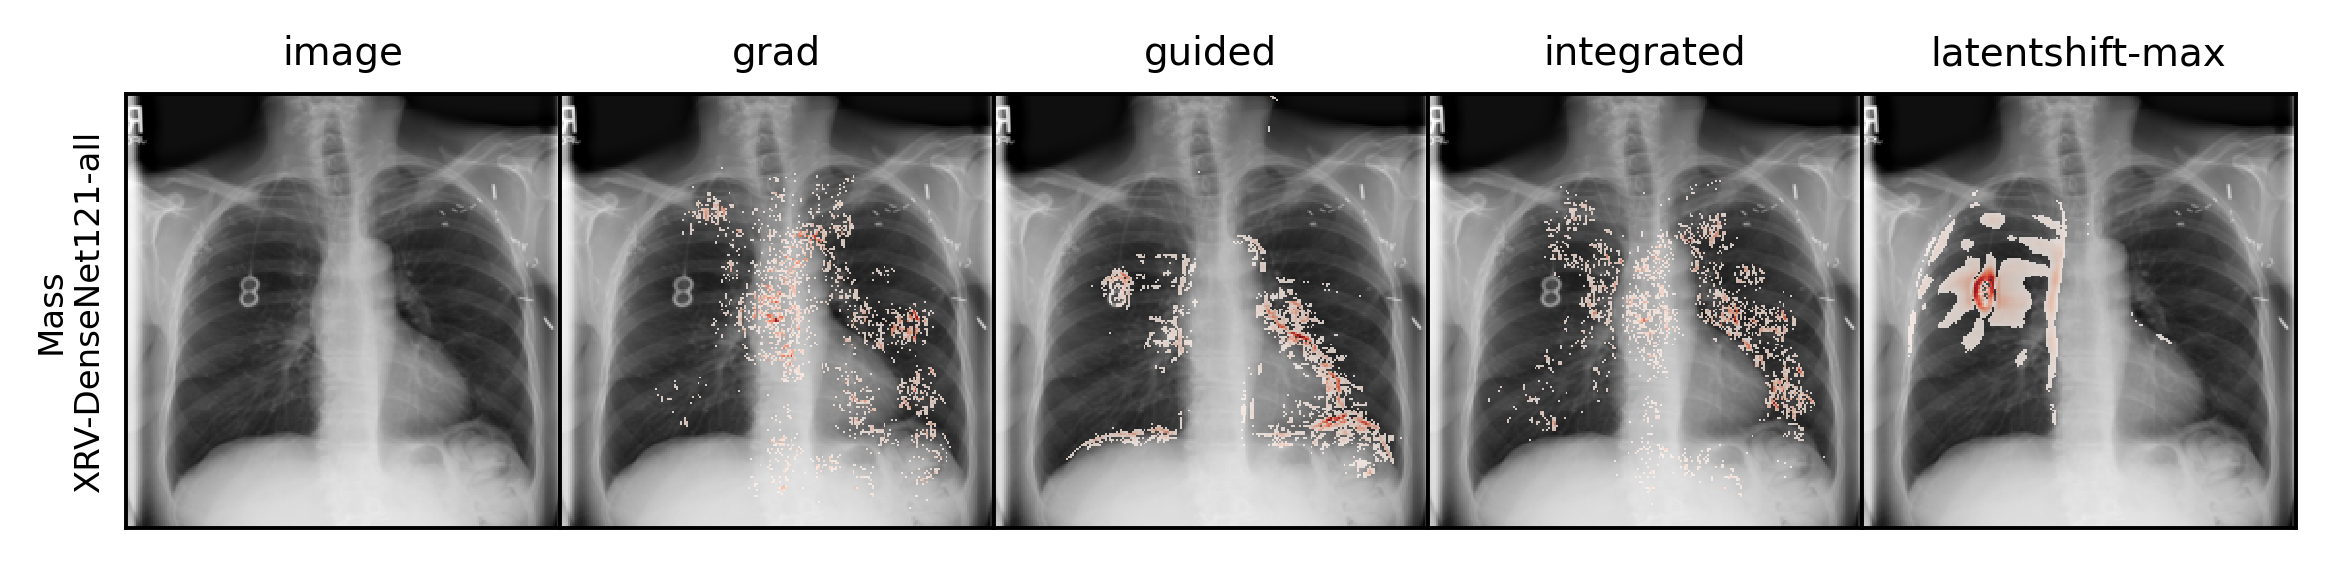

In [174]:
attribution.generate_attributions(sample, model, target, ae, temp_path, dmerge)

tensor([0.2025])
[0.5089496] -190 50


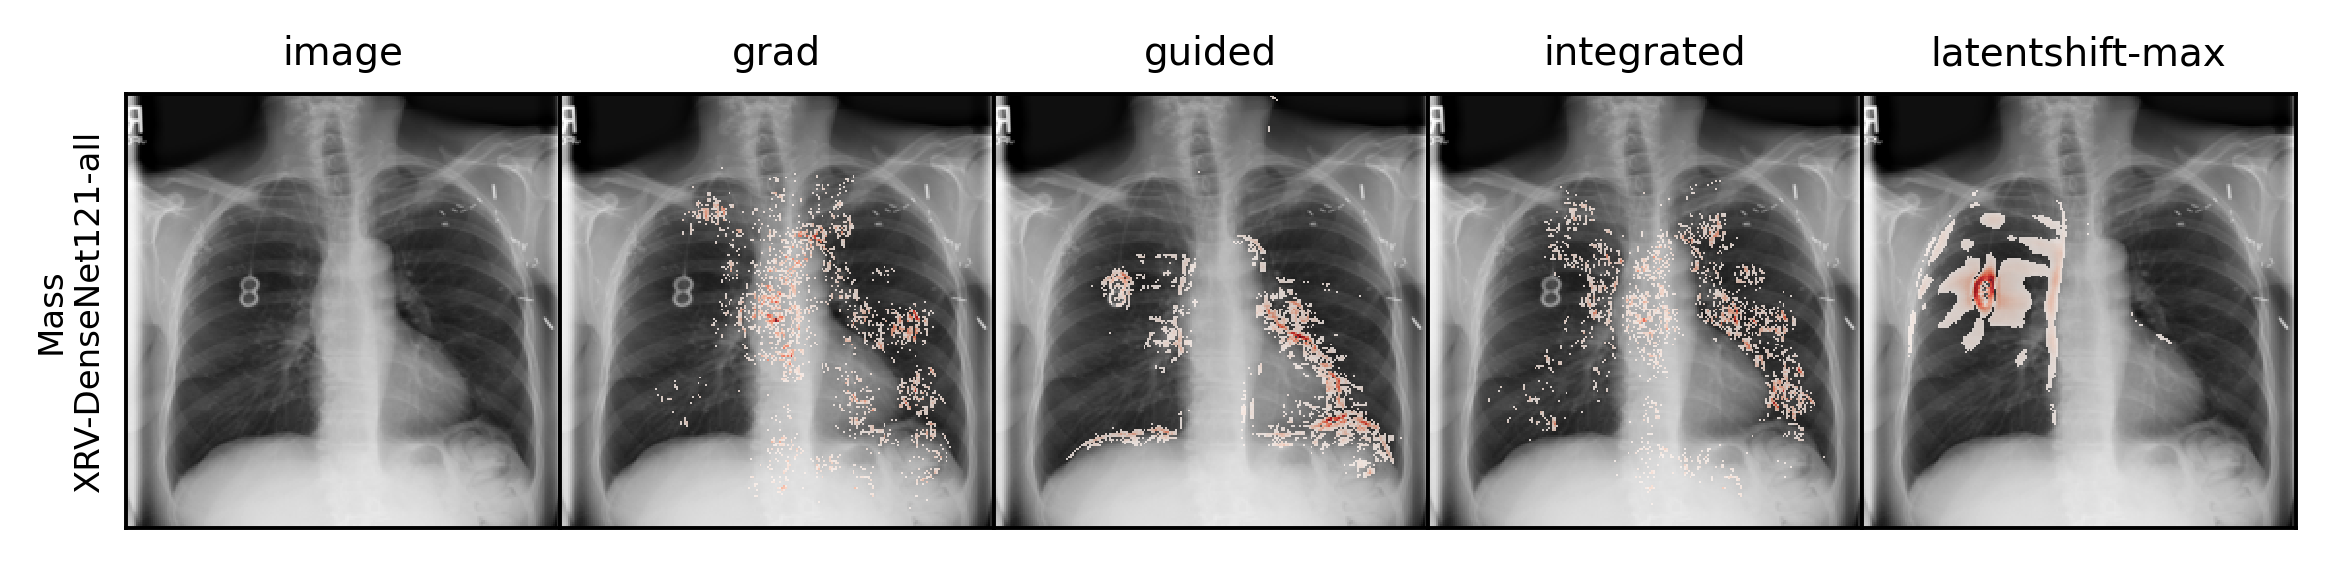

In [160]:
attribution.generate_attributions(sample, model, target, ae, temp_path, dmerge)

In [120]:
len(range(0,50,5))

10

In [20]:
targets = ['Mass', 'Pneumothorax']

In [ ]:
for target in targets:
    perf = pd.DataFrame()
    for noise in range(0,50,10):
        print(noise)
        data_aug = torchvision.transforms.Compose([
            xrv.datasets.ToPILImage(),
            torchvision.transforms.ToTensor(),
            #torchvision.transforms.Lambda(lambda x: x + torch.rand(x.shape)*100*noise),
            torchvision.transforms.Lambda(lambda x: x.numpy()),
            torchvision.transforms.Lambda(lambda x: skimage.filters.gaussian(x[0], 
                            mode='constant', 
                            sigma=(noise,noise), 
                            truncate=3.5)[None,...]),
            ])

        dataset = for_eval[target]

        h = attribution.run_eval(target, dataset, model, ae=ae, limit=80, data_aug=data_aug)
        h["model"] = str(model)
        h["target"] = target
        h["noise"] = noise

        perf = perf.append(h, ignore_index=True)
        
    perf.to_csv("perf-blur-{}.csv".format(target))


In [50]:
perf.to_csv("perf-noise-{}.csv".format(target))

In [9]:
#perf = pd.read_csv("perf-noise.csv")

In [6]:
pathos = ['Cardiomegaly','Atelectasis', 'Effusion', 'Lung Opacity',  'Mass', 'Pneumothorax']

Cardiomegaly grad 780
Cardiomegaly guided 780
Cardiomegaly integrated 780
Cardiomegaly latentshift-max 780
Atelectasis grad 810
Atelectasis guided 810
Atelectasis integrated 810
Atelectasis latentshift-max 810
Effusion grad 810
Effusion guided 810
Effusion integrated 810
Effusion latentshift-max 810
Lung Opacity grad 810
Lung Opacity guided 810
Lung Opacity integrated 810
Lung Opacity latentshift-max 810
Mass grad 520
Mass guided 520
Mass integrated 520
Mass latentshift-max 520
Pneumothorax grad 810
Pneumothorax guided 810
Pneumothorax integrated 810
Pneumothorax latentshift-max 810


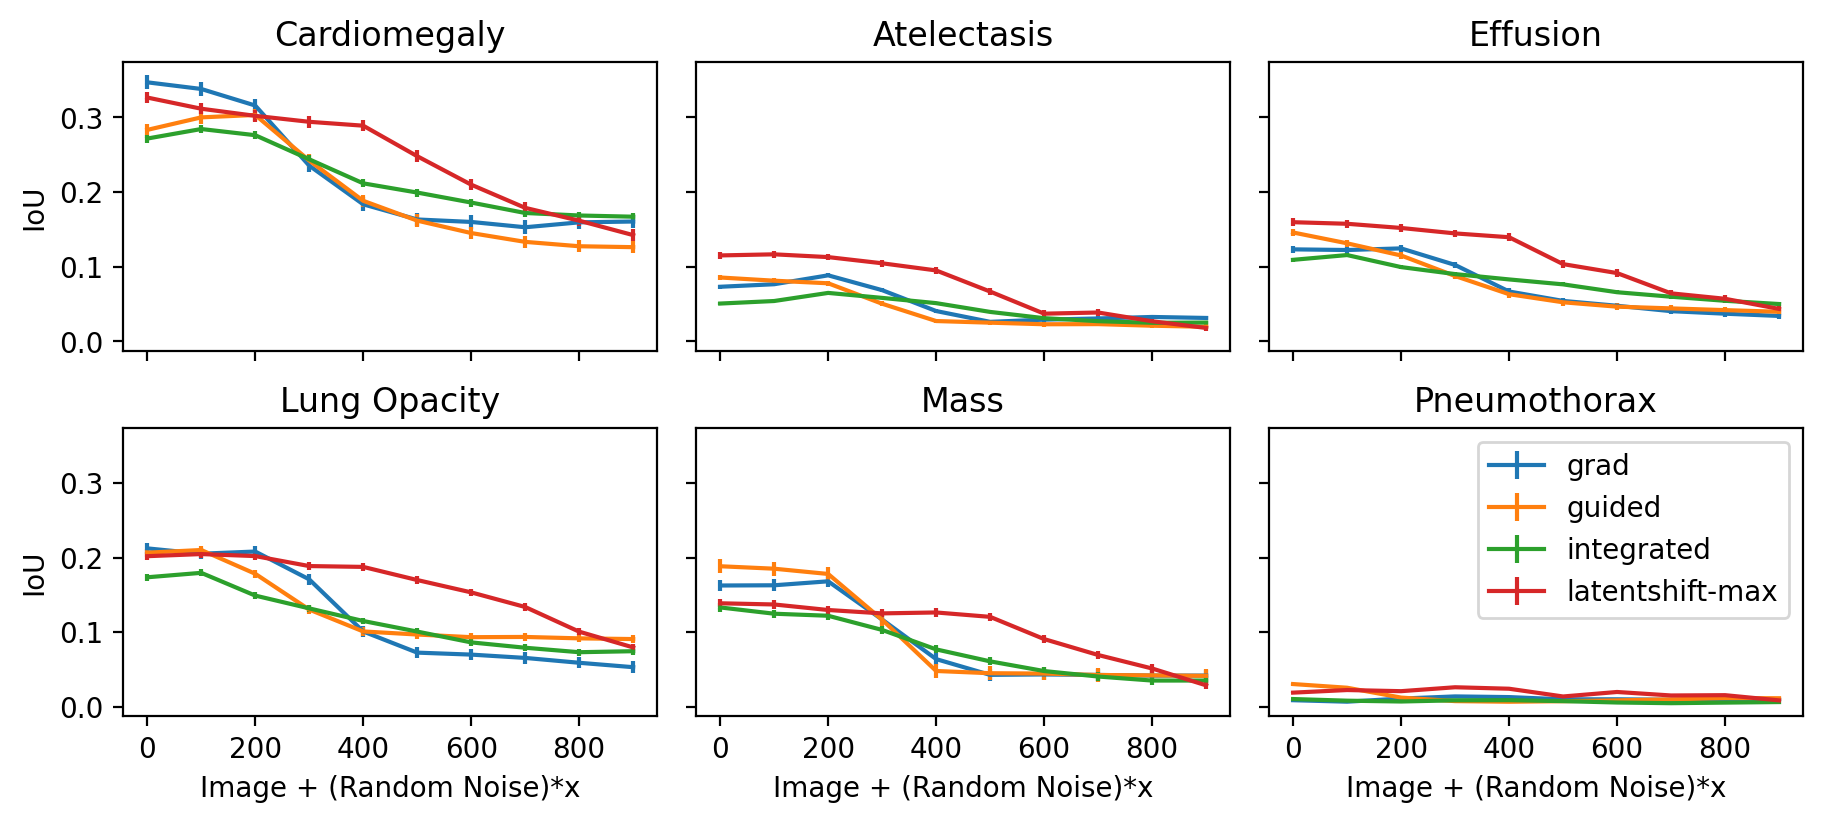

In [37]:
fig, ax = plt.subplots(2,3, figsize=(9,4), dpi=200, constrained_layout=True, facecolor='w', sharex=True, sharey=True)

for i, target in enumerate(pathos):
    perf = pd.read_csv("perf-noise-{}.csv".format(target))
    for name, row in perf.groupby(["method"]):
        print(target, name, len(row)) 
        d = row.groupby(["noise"])[["iou"]].mean().reset_index()
        count = float(row.groupby(["noise"])[["iou"]].count().iloc[0])
        ax[i//3,i%3].errorbar(d["noise"]*100, d["iou"], d["iou"].std()/np.sqrt(count),label=name)
        ax[i//3,i%3].set_title(target)

ax[1,0].set_xlabel("Image + (Random Noise)*x")
ax[1,1].set_xlabel("Image + (Random Noise)*x")
ax[1,2].set_xlabel("Image + (Random Noise)*x")

ax[0,0].set_ylabel("IoU")
ax[1,0].set_ylabel("IoU")

ax[1,2].legend();


Cardiomegaly grad 390
Cardiomegaly guided 390
Cardiomegaly integrated 390
Cardiomegaly latentshift-max 390
Atelectasis grad 405
Atelectasis guided 405
Atelectasis integrated 405
Atelectasis latentshift-max 405
Effusion grad 405
Effusion guided 405
Effusion integrated 405
Effusion latentshift-max 405
Lung Opacity grad 405
Lung Opacity guided 405
Lung Opacity integrated 405
Lung Opacity latentshift-max 405
Mass grad 260
Mass guided 260
Mass integrated 260
Mass latentshift-max 260
Pneumothorax grad 405
Pneumothorax guided 405
Pneumothorax integrated 405
Pneumothorax latentshift-max 405


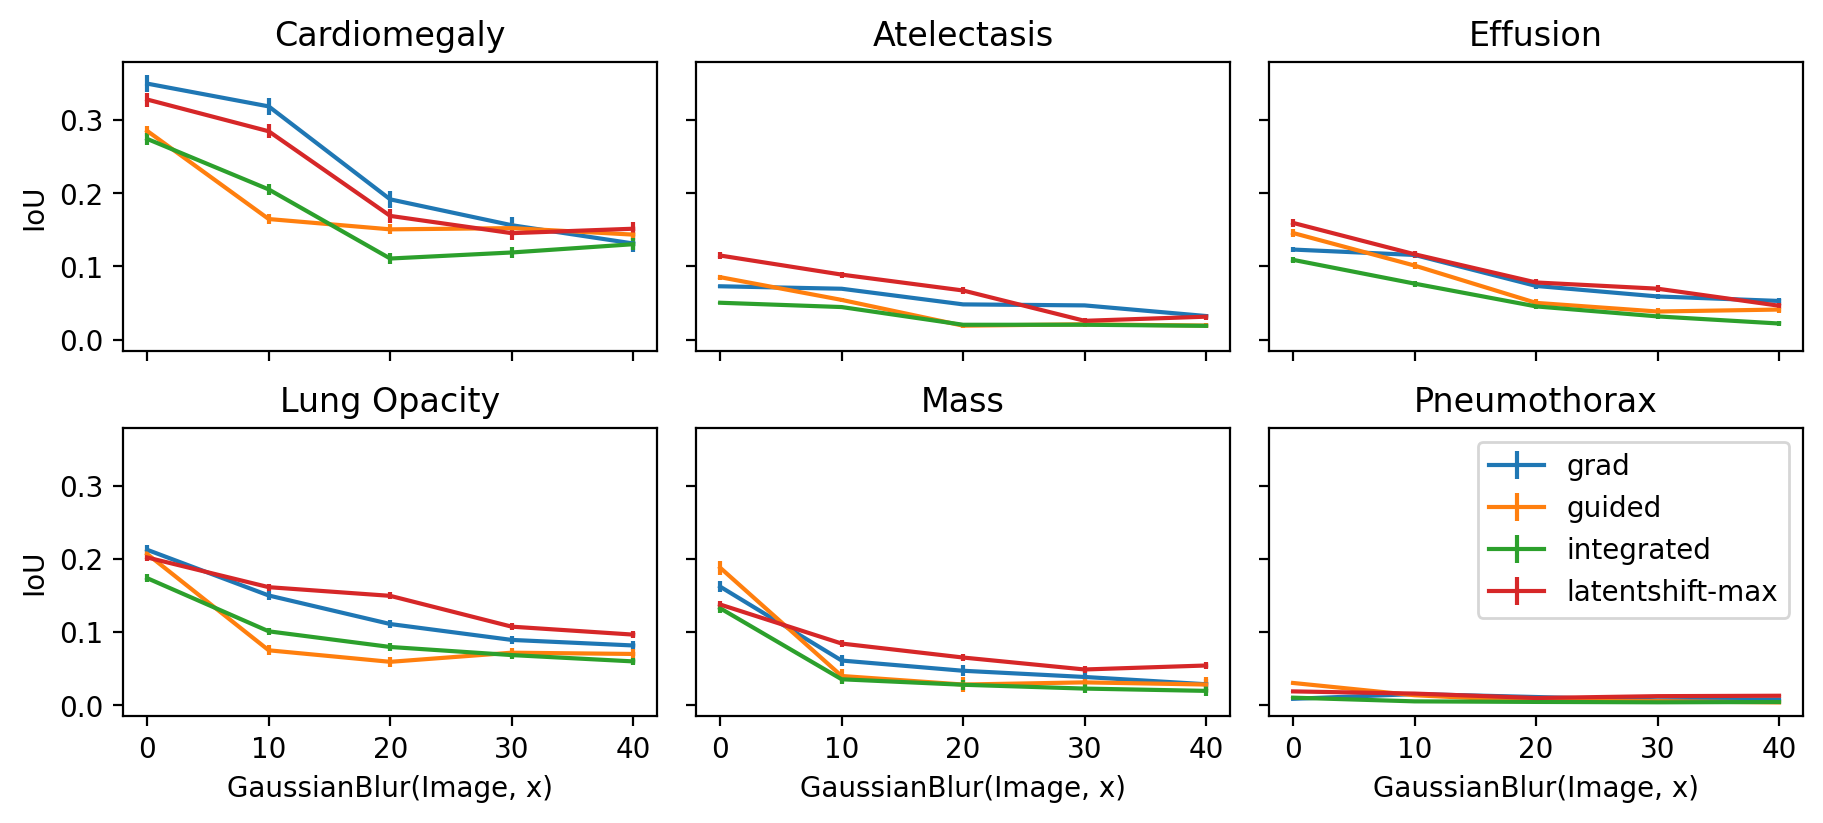

In [36]:
fig, ax = plt.subplots(2,3, figsize=(9,4), dpi=200, constrained_layout=True, facecolor='w', sharex=True, sharey=True)

for i, target in enumerate(pathos):
    perf = pd.read_csv("perf-blur-{}.csv".format(target))
    for name, row in perf.groupby(["method"]):
        print(target, name, len(row)) 
        d = row.groupby(["noise"])[["iou"]].mean().reset_index()
        count = float(row.groupby(["noise"])[["iou"]].count().iloc[0])
        ax[i//3,i%3].errorbar(d["noise"], d["iou"], d["iou"].std()/np.sqrt(count),label=name)
        ax[i//3,i%3].set_title(target)

ax[1,0].set_xlabel("GaussianBlur(Image, x)")
ax[1,1].set_xlabel("GaussianBlur(Image, x)")
ax[1,2].set_xlabel("GaussianBlur(Image, x)")

ax[0,0].set_ylabel("IoU")
ax[1,0].set_ylabel("IoU")

ax[1,2].legend();
